# Requirements
tensorflow,
skimage,
numpy,
image folders

In [1]:
%pwd

'C:\\Users\\DELL\\Downloads\\Face Mask Detection\\dataset'

In [1]:
from skimage.transform import resize
from skimage import io

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

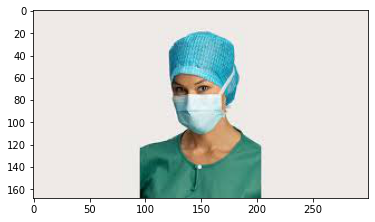

In [3]:
img=plt.imread(r"C:\Users\DELL\Downloads\Face Mask Detection\dataset\with_mask\2.jpeg")
plt.imshow(img)

In [4]:
img.shape

(168, 300, 3)

In [5]:
def get_images(img_folder):
    #os library is used to scan the folder and store the filenames of the images
    filenames = [f.path for f in os.scandir(img_folder) if f.is_file() and f.path.endswith(('.jpg', '.jpeg'))]
    print('length of given folder is ',len(filenames))
    img = []
    #this loop reads the images data and store into array
    for i in range(len(filenames)):
        img.append(plt.imread(filenames[i]))
    res_img = []
    # resizing of images done using resize function from skimage library
    for i in range(len(img)) :
        res_img.append(resize(img[i], (299,299)))
    # converting list of images to array as neural network models take arrays as input not lists
    import numpy as np
    r_img = np.array(res_img)
    return r_img

In [6]:
A=get_images('without_mask')

length of given folder is  343


In [7]:
B=get_images('with_mask')

length of given folder is  387


In [8]:
#we have read RGBA values of images, we need only RGB values so we have taken only first 3 channels of each pixel
A=A[:,:,:,:3]

In [9]:
B=B[:,:,:,:3]

In [10]:
a=[]
b=[]
for i in range(len(A)):
    a.append(1)
for i in range(len(B)):
    b.append(0)

In [11]:
X=np.array(list(A)+list(B))
y=np.array(a+b)

In [12]:
#splitting data into training, testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15)
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2

In [13]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape) 
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (620, 299, 299, 3)
X_test.shape:  (110, 299, 299, 3)
y_train.shape:  (620,)
y_test.shape:  (110,)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# datA augmentation creates new images by rotating, width shifting etc which lets our model not to overfit
aug=ImageDataGenerator(
    
    width_shift_range=[0.1,0.4],
    horizontal_flip=True,
    vertical_flip=True
)

In [16]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2

# Architecture

In [18]:
#using vgg architecture 
xception = Xception(input_shape=(299,299,3), weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in xception.layers:
    layer.trainable = False

In [19]:
x = Flatten()(xception.output)

x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(112, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(56, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

prediction = Dense(1, activation='sigmoid')(x)

#creating model
model1 = Model(inputs=xception.input, outputs=prediction)

In [20]:
#displaying the model architecture
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [21]:
opt =Adam(learning_rate=0.001)    #SGD

In [22]:
#optimizer is the way our model is learning from the losses
model1.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [23]:
#training using vgg model
history=model1.fit(X_train,y_train,epochs=20,batch_size=15)

Epoch 1/20
42/42 [==============================] - 105s 2s/step - loss: 0.2934 - accuracy: 0.8726
Epoch 2/20
42/42 [==============================] - 106s 3s/step - loss: 0.1238 - accuracy: 0.9597
Epoch 3/20
42/42 [==============================] - 107s 3s/step - loss: 0.0938 - accuracy: 0.9726
Epoch 4/20
42/42 [==============================] - 106s 3s/step - loss: 0.0690 - accuracy: 0.9823
Epoch 5/20
42/42 [==============================] - 105s 3s/step - loss: 0.0363 - accuracy: 0.9919
Epoch 6/20
42/42 [==============================] - 107s 3s/step - loss: 0.0494 - accuracy: 0.9823
Epoch 7/20
42/42 [==============================] - 106s 3s/step - loss: 0.0409 - accuracy: 0.9903
Epoch 8/20
42/42 [==============================] - 17901s 426s/step - loss: 0.0178 - accuracy: 0.9968
Epoch 9/20
42/42 [==============================] - 140s 3s/step - loss: 0.0270 - accuracy: 0.9919
Epoch 10/20
42/42 [==============================] - 148s 4s/step - loss: 0.0314 - accuracy: 0.9887
Epoch

<AxesSubplot:>

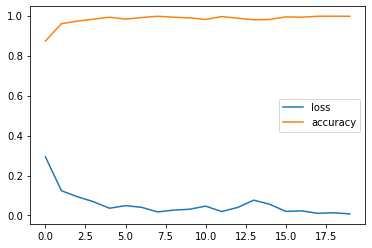

In [24]:
# plot of losses and accuracies, losses should decrease and accuracy should increase
import pandas as pd
hs=pd.DataFrame(model1.history.history)
hs.plot()

In [25]:
pred=model1.predict(X_test)
pred

array([[9.9994808e-01],
       [8.3178282e-04],
       [6.3974418e-05],
       [9.9994028e-01],
       [2.2774935e-04],
       [9.9997866e-01],
       [9.9996877e-01],
       [1.8612921e-02],
       [9.9816692e-01],
       [2.9162304e-05],
       [9.9982905e-01],
       [9.9999404e-01],
       [2.9957294e-04],
       [1.3195276e-03],
       [3.4537911e-04],
       [9.9920845e-01],
       [9.9999803e-01],
       [7.6675415e-04],
       [9.9178064e-01],
       [1.1137217e-02],
       [2.6613474e-04],
       [9.9999213e-01],
       [9.9988031e-01],
       [9.9355674e-01],
       [9.9997532e-01],
       [2.2506714e-04],
       [2.1016598e-04],
       [2.6538968e-04],
       [9.9997091e-01],
       [9.9725443e-01],
       [4.8452616e-04],
       [9.9996984e-01],
       [9.9999499e-01],
       [1.8194318e-04],
       [9.9916250e-01],
       [2.8407574e-04],
       [4.9000978e-04],
       [1.5605569e-02],
       [9.9981314e-01],
       [9.9981856e-01],
       [9.9986875e-01],
       [2.551972

In [26]:
L=[]
for i in pred:
    if i>0.5:  #we can set any threshold from 0.3 to 0.9
        L.append(1)
    else:
        L.append(0)

In [27]:
p=np.array(L)
p

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        53

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110



In [31]:
import os.path
if os.path.isfile('facemaskdetection_100%.h5') is False:
    
    model1.save('facemaskdetection_100%%.h5')

In [6]:
from tensorflow.keras.models import load_model

new_model = load_model('facemaskdetection_100%%.h5')

In [4]:
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [12]:
#from tensorflow.keras.layers import Layer
len(new_model.layers)

143

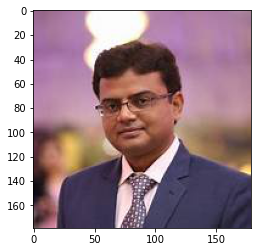

In [63]:
sample=plt.imread('6.jfif')   
plt.imshow(sample) 

In [64]:
sample.shape

(179, 179, 3)

In [65]:
import cv2
im1=cv2.resize(sample,(299,299))

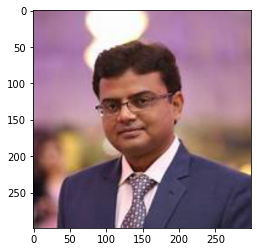

In [66]:
plt.imshow(im1)

In [67]:
im2=im1.reshape(1,299,299,3)

In [68]:
im2.shape

(1, 299, 299, 3)

In [69]:
new_model.predict(im2)       # Predicted 1 since image has without mask

array([[1.]], dtype=float32)